# Batch GP tutorial
This code is the official GPyTorch tutorial for batch GP regression: https://docs.gpytorch.ai/en/stable/examples/08_Advanced_Usage/Simple_Batch_Mode_GP_Regression.html

Iter 1/50 - Loss: 3.442
Iter 2/50 - Loss: 3.281
Iter 3/50 - Loss: 3.119
Iter 4/50 - Loss: 2.958
Iter 5/50 - Loss: 2.797
Iter 6/50 - Loss: 2.638
Iter 7/50 - Loss: 2.481
Iter 8/50 - Loss: 2.325
Iter 9/50 - Loss: 2.172
Iter 10/50 - Loss: 2.019
Iter 11/50 - Loss: 1.867
Iter 12/50 - Loss: 1.715
Iter 13/50 - Loss: 1.562
Iter 14/50 - Loss: 1.408
Iter 15/50 - Loss: 1.254
Iter 16/50 - Loss: 1.098
Iter 17/50 - Loss: 0.942
Iter 18/50 - Loss: 0.785
Iter 19/50 - Loss: 0.628
Iter 20/50 - Loss: 0.472
Iter 21/50 - Loss: 0.318
Iter 22/50 - Loss: 0.165
Iter 23/50 - Loss: 0.016
Iter 24/50 - Loss: -0.130
Iter 25/50 - Loss: -0.272
Iter 26/50 - Loss: -0.408
Iter 27/50 - Loss: -0.539
Iter 28/50 - Loss: -0.663
Iter 29/50 - Loss: -0.781
Iter 30/50 - Loss: -0.892
Iter 31/50 - Loss: -0.996
Iter 32/50 - Loss: -1.092
Iter 33/50 - Loss: -1.180
Iter 34/50 - Loss: -1.260
Iter 35/50 - Loss: -1.329
Iter 36/50 - Loss: -1.389
Iter 37/50 - Loss: -1.439
Iter 38/50 - Loss: -1.479
Iter 39/50 - Loss: -1.509
Iter 40/50 - Loss:

Text(0.5, 1.0, 'Observed Values (Likelihood)')

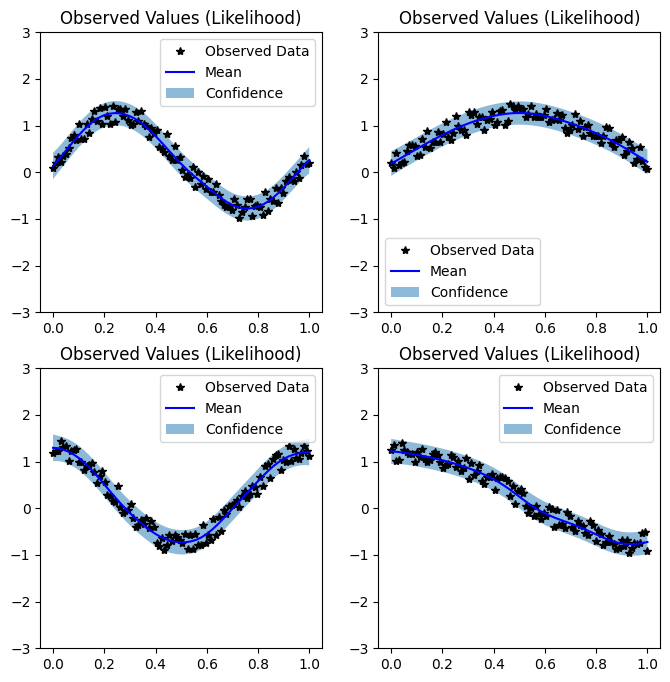

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt


# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100).view(1, -1, 1).repeat(4, 1, 1)
# True functions are sin(2pi x), cos(2pi x), sin(pi x), cos(pi x)
sin_y = torch.sin(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
sin_y_short = torch.sin(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y = torch.cos(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y_short = torch.cos(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
train_y = torch.cat((sin_y, sin_y_short, cos_y, cos_y_short)).squeeze(-1)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([4]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(batch_shape=torch.Size([4])),
            batch_shape=torch.Size([4])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([4]))
model = ExactGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, ((y1_ax, y2_ax), (y3_ax, y4_ax)) = plt.subplots(2, 2, figsize=(8, 8))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).view(1, -1, 1).repeat(4, 1, 1)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()


# Plot training data as black stars
y1_ax.plot(train_x[0].detach().numpy(), train_y[0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x[0].squeeze().numpy(), mean[0, :].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x[0].squeeze().numpy(), lower[0, :].numpy(), upper[0, :].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

y2_ax.plot(train_x[1].detach().numpy(), train_y[1].detach().numpy(), 'k*')
y2_ax.plot(test_x[1].squeeze().numpy(), mean[1, :].numpy(), 'b')
y2_ax.fill_between(test_x[1].squeeze().numpy(), lower[1, :].numpy(), upper[1, :].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

y3_ax.plot(train_x[2].detach().numpy(), train_y[2].detach().numpy(), 'k*')
y3_ax.plot(test_x[2].squeeze().numpy(), mean[2, :].numpy(), 'b')
y3_ax.fill_between(test_x[2].squeeze().numpy(), lower[2, :].numpy(), upper[2, :].numpy(), alpha=0.5)
y3_ax.set_ylim([-3, 3])
y3_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y3_ax.set_title('Observed Values (Likelihood)')

y4_ax.plot(train_x[3].detach().numpy(), train_y[3].detach().numpy(), 'k*')
y4_ax.plot(test_x[3].squeeze().numpy(), mean[3, :].numpy(), 'b')
y4_ax.fill_between(test_x[3].squeeze().numpy(), lower[3, :].numpy(), upper[3, :].numpy(), alpha=0.5)
y4_ax.set_ylim([-3, 3])
y4_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y4_ax.set_title('Observed Values (Likelihood)')